In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os



import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox



from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX


# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score

from sklearn.linear_model import LinearRegression


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor


from scipy import signal
from scipy import stats

sys.path.append("..")
from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline

In [3]:
data_014706 = pd.read_pickle("../../data/pickled_data/merged_data_014706_hourly.pkl")
weather_data = pd.read_pickle("../../data/pickled_data/weather_data.pkl")
weather_data.set_index('DATE')
weather_data = weather_data.drop(['level_0', 'index'], axis=1)

In [4]:
data_014706.head(5)

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,DATE,level_0,index,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE
Start Time,,,,,,,,,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 01:00:00,0,7,2018,1,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 02:00:00,0,7,2018,2,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 03:00:00,0,7,2018,3,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 04:00:00,0,7,2018,4,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0


In [5]:
data_014706_2 = data_014706
data_014706_2 = data_014706_2.drop(['MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY', 'DATE', 'level_0', 'index',
       'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW', 'AVG_TEMPERATURE',
       'MAX_TEMPERATURE', 'MIN_TEMPERATURE'], axis=1)
data_014706_2_hour = data_014706_2.resample('4H', how='sum')
data_014706_2_hour = data_014706_2_hour.fillna(0)
data_014706_2_hour.head(5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


,014706
Start Time,
2018-07-15 00:00:00,1
2018-07-15 04:00:00,1
2018-07-15 08:00:00,10
2018-07-15 12:00:00,9
2018-07-15 16:00:00,8


In [6]:
# Do the resampling before you add all the features

data_014706_2_hour['MONTH'] = pd.DatetimeIndex(data_014706_2_hour.index).month
data_014706_2_hour['YEAR'] = pd.DatetimeIndex(data_014706_2_hour.index).year
data_014706_2_hour['HOUR'] = pd.DatetimeIndex(data_014706_2_hour.index).hour
data_014706_2_hour['DAY'] = pd.DatetimeIndex(data_014706_2_hour.index).day
data_014706_2_hour['WEEK'] = pd.DatetimeIndex(data_014706_2_hour.index).week
data_014706_2_hour['DAY_OF_WEEK'] = pd.DatetimeIndex(data_014706_2_hour.index).weekday
data_014706_2_hour['WEEKEND'] = ((pd.DatetimeIndex(data_014706_2_hour.index).weekday) // 5 == 1).astype(float)
data_014706_2_hour['WEEKDAY'] = ((pd.DatetimeIndex(data_014706_2_hour.index).weekday) // 5 == 0).astype(float)
data_014706_2_hour['DATE'] = pd.DatetimeIndex(data_014706_2_hour.index).date
data_014706_2_hour.head(5)

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,DATE
Start Time,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,2018-07-15
2018-07-15 04:00:00,1,7,2018,4,15,28,6,1.0,0.0,2018-07-15
2018-07-15 08:00:00,10,7,2018,8,15,28,6,1.0,0.0,2018-07-15
2018-07-15 12:00:00,9,7,2018,12,15,28,6,1.0,0.0,2018-07-15
2018-07-15 16:00:00,8,7,2018,16,15,28,6,1.0,0.0,2018-07-15


In [7]:
# Add Weather Data 
data_014706_2_hour = data_014706_2_hour.reset_index().merge(weather_data, on='DATE', how="left").set_index('Start Time')
data_014706_2_hour.head(5)

# Drop DATE, level_0, index columns
#data_014706_2_hour = data_014706_2_hour.drop(['DATE', 'index', 'level_0'], axis=1)



,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,DATE,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE
Start Time,,,,,,,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 04:00:00,1,7,2018,4,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 08:00:00,10,7,2018,8,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 12:00:00,9,7,2018,12,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 16:00:00,8,7,2018,16,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0


In [9]:
data_014706_2_hour = data_014706_2_hour.drop(['DATE'], axis=1)

In [72]:
#data_014706_2_hour_p = pd.merge(left=data_014706_2_hour,right=weather_data, how='left',left_on='DATE', right_on='DATE')
#merged_data_014706_hourly = data_014706_hourly.reset_index().merge(weather_data, on='DATE', how="left").set_index('Start Time')


In [10]:
data_014706_2_hour.columns

Index(['014706', 'MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY', 'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW',
       'AVG_TEMPERATURE', 'MAX_TEMPERATURE', 'MIN_TEMPERATURE'],
      dtype='object')

In [11]:
# Create the test train split the same way as the univariate time series so this is the same as ARIMA series
size = int(len(data_014706_2_hour) * 0.66)
train, test = data_014706_2_hour[0:size], data_014706_2_hour[size:len(data_014706_2_hour)]
# train = train.drop([ 'index', 'level_0'], axis=1)
# test = test.drop([ 'index','level_0'], axis=1)
# train.pop('DATE')
# train.pop('index')
# test.pop('DATE')
# test.pop('index')

In [12]:
y_train = train.pop('014706').values
X_train = train.values
y_test = test.pop('014706').values
X_test = test.values


In [13]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    score = model.score(test_features, test_labels)
    print('Model Performance')
    print("Mean Square Error:", mean_squared_error(test_labels, predictions))
    print("Mean Absoulute Error:", mean_absolute_error(test_labels, predictions))
    print("Score:", score)
    return score

In [14]:
best_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

best_rf.fit(X_train, y_train)
best_random_forest_accuracy = evaluate(best_rf, X_test, y_test)

Model Performance
Mean Square Error: 85.33142052532327
Mean Absoulute Error: 5.189242605005918
Score: 0.5339158891419821


In [15]:
best_rf_predictions = best_rf.predict(X_test)

In [69]:
train.head(5)

,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,level_0_x,index_x,...,SNOW_y,AVG_TEMPERATURE_y,MAX_TEMPERATURE_y,MIN_TEMPERATURE_y,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE
Start Time,,,,,,,,,,,,,,,,,,,,,
2018-07-15 00:00:00,7,2018,0,15,28,6,1.0,0.0,102,195,...,0.0,86.0,98.0,75.0,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 02:00:00,7,2018,2,15,28,6,1.0,0.0,102,195,...,0.0,86.0,98.0,75.0,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 04:00:00,7,2018,4,15,28,6,1.0,0.0,102,195,...,0.0,86.0,98.0,75.0,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 06:00:00,7,2018,6,15,28,6,1.0,0.0,102,195,...,0.0,86.0,98.0,75.0,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 08:00:00,7,2018,8,15,28,6,1.0,0.0,102,195,...,0.0,86.0,98.0,75.0,10.29,0.0,0.0,86.0,98.0,75.0


In [16]:
for i,j in  zip(train.columns.tolist(), best_rf.feature_importances_):
    print(i, ":", j)

MONTH : 0.01387732289003394
YEAR : 0.0
HOUR : 0.7333406835570372
DAY : 0.02714324440827726
WEEK : 0.03258820694096823
DAY_OF_WEEK : 0.0659343833190009
WEEKEND : 0.005928258078538121
WEEKDAY : 0.007785488568569401
AVG_DAILY_WIND_SPEED : 0.020871592736052862
PRECIPITATION : 0.021598634777256414
SNOW : 0.0
AVG_TEMPERATURE : 0.019578890920529862
MAX_TEMPERATURE : 0.03677951546727198
MIN_TEMPERATURE : 0.014573778336464019


In [17]:
size = int(len(data_014706_2_hour) * 0.66)
train_1, test_1 = data_014706_2_hour[0:size], data_014706_2_hour[size:len(data_014706_2_hour)]

In [18]:
test_results = test_1.drop(['MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY',
       'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW', 'AVG_TEMPERATURE',
       'MAX_TEMPERATURE', 'MIN_TEMPERATURE'], axis=1)
test_results.rename(columns=dict(zip(["014706"], ["Actual"])), inplace=True)
rf_list = best_rf_predictions.tolist()
test_results['rf_predictions'] = rf_list

In [23]:
test_results.head(5)

,Actual,rf_predictions
Start Time,,
2018-11-13 08:00:00,1,1.224114
2018-11-13 10:00:00,0,3.602054
2018-11-13 12:00:00,2,4.997764
2018-11-13 14:00:00,0,5.959846
2018-11-13 16:00:00,6,7.884720


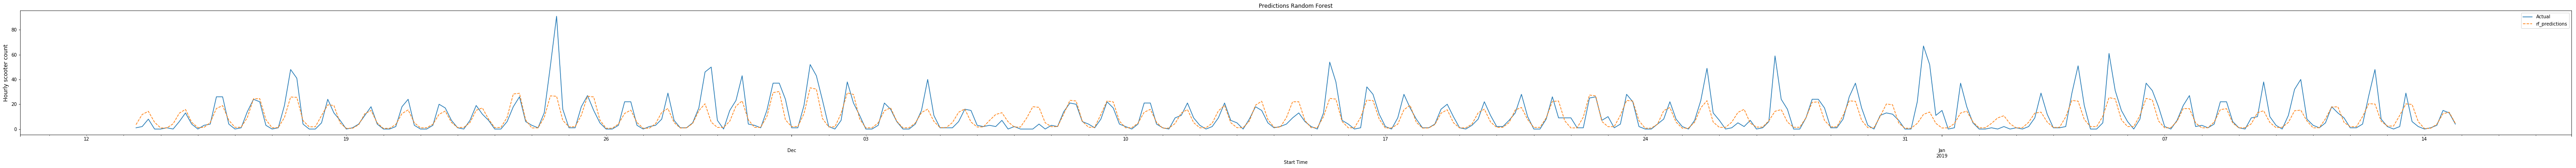

In [19]:
test_results.plot(style=['-', '--', ':'],figsize=(100, 5))
plt.title('Predictions Random Forest')
plt.ylabel('Hourly scooter count', fontsize=12)
plt.savefig('../../output/Random_Forest_Predictions_Two_Hour.png')

In [20]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3,5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(X_train, y_train)
#print("Grid Search Best Parameters:" grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   2.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3,

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.8s


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_

[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_s

[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.4s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   2.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_s

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   44.7s


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, 

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   2.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   2.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3,

[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.5s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.5s
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_lea

[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   2.6s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   2.6s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=5, m

[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   2.5s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   2.6s
[CV] bootstrap=True, max_depth=90, max_features=5, m

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.3min


[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   2.5s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=5

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.5s
[CV]  bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fea

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_f

[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_f

[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=   2.7s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_

[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=   2.5s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   2.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   2.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=   2.4s
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_d

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.1min


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_featur

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_fe

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   2.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_fea

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   2.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   2.8s
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   2.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000, total=   2.8s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=   3.6s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=5, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_fe

[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  2.8min finished


Model Performance
Mean Square Error: 90.22614260089868
Mean Absoulute Error: 5.439264619443534
Score: 0.5071806939179127
